In [4]:
import os
import pandas as pd
import numpy as np
import biosignalsnotebooks as bsnb
from numpy import linspace, diff, zeros_like, arange, array
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import correlate
import scipy as sp
from scipy.signal import find_peaks
import math
from scipy import signal as scisig
import neurokit2 as nk
import statistics

#Function definition for Step 1 of the Pan-Tomkins Algorithm
def _filtering(signal, rate):
    filtered_signal = bsnb.detect._ecg_band_pass_filter(signal, rate)
    return filtered_signal

#Function definition for Step 2 of the Pan-Tomkins Algorithm
def _differentiation(signal):
    differentiated_signal = diff(signal)
    return differentiated_signal

#Function definition for Step 3 of the Pan-Tomkins Algorithm
def _squaring(signal):
    squared_signal = signal * signal
    return squared_signal

#Function definition for Step 4 of the Pan-Tomkins Algorithm
def _integration(signal,rate):
    nbr_sampls_int_wind = int(0.080 * rate)
    integrated_signal = zeros_like(signal)
    cumulative_sum = signal.cumsum()
    integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
    integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / arange(1, nbr_sampls_int_wind + 1)
    return integrated_signal

#Function definition for peak correction.
def _peak_detection(signal,rate):
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=rate) 
    return rpeaks

#Function definition for correction the peak detection from the integrated signal to the original signal.
def _correct_peaks(signal, rate, peaks):
    left_add = int(0.075 * rate)
    right_add = int(0.075 * rate)
    i = 0
    # TODO: debug
    while i < len(peaks['ECG_R_Peaks']):
        old_index = peaks['ECG_R_Peaks'][i]
        begin = max(old_index - left_add, 1)
        end = min(old_index + right_add, len(signal) - 1)
        baseline = (signal[begin] + signal[end]) / 2
        max_value = math.fabs(signal[old_index] - baseline)
        new_index = old_index
        for j in range(begin, end):
            value = math.fabs(signal[j] - baseline)
            if value > max_value:
                max_value = value
                new_index = j
        if new_index != old_index:
            peaks['ECG_R_Peaks'][i] = new_index
        i += 1
    return peaks['ECG_R_Peaks']

#Function definition for plotting any signal.
def _plotting_signal(signal):
    signal, = plt.plot(signal)
    x_data = signal.get_xdata()
    plt.show()
    return x_data

#Function definition for plotting any signal and the R-peaks detected.
def _plotting_rinterval(signal, x_data, peaks):
    y_values = []
    for point in peaks:
        value = np.interp(point, x_data, signal)
        y_values.append(value)
    
    plt.plot(signal)
    plt.scatter(peaks,y_values,marker='o',c='red')
    plt.show()
    
    plt.plot(signal)    
    plt.scatter(peaks,y_values,marker='o',c='red')
    plt.axis([0, 10000, -1000, 2000])
    plt.show()


In [124]:
def _pantompkins(signal, rate):
    filtered_signal = _filtering(signal,rate)
    differentiated_signal = _differentiation(filtered_signal)
    squared_signal = _squaring(differentiated_signal)
    integrated_signal = _integration(squared_signal,rate)
    integrated_peaks = _peak_detection(integrated_signal,rate)
    signal_peaks = _correct_peaks(signal,rate,integrated_peaks)
    
    return signal_peaks
    
    

In [125]:
def _hrvreading(peaks):
    hrv_values_c = []
    for index, value in enumerate(peaks): #The HRV values are calculated inside this for loop. The for loop ends if the index values get bigger than the array itself.
        if index+1 == len(peaks) :
            break
        hrv_values_c.append(peaks[index+1]-peaks[index])
    
    hrv_values_c_m = np.mean(hrv_values_c) #The mean value of the HRV signal is calculated and subtracted from the original HRV signal.
    hrv_values_c = hrv_values_c - hrv_values_c_m
 
    hrv_data = []
    n = 0
    while n < len(hrv_values_c): #To account for outliers and peaks values which may be due to an error in reading, a sliding window is performed.
        i = 0
        window_values = []
        while i < 20: # The sliding window has a value of 20
            if n >= len(hrv_values_c):
                break
            window_values.append(hrv_values_c[n])
            n += 1
            i += 1
        mean = np.mean(window_values) # The values that are found to be two standard deviations from the mean are changed by the mean value of the window.
        std = statistics.stdev(window_values)
        for index, value in enumerate(window_values):
            if value > (mean+2*std) or value < -(mean+2*std):
                window_values[index] = mean
                
        hrv_data = hrv_data + window_values
        n += 1
    
    time = bsnb.generate_time(hrv_data) #The data is then plotted to reconstruct the signal.
    plt.plot(time,hrv_data)
    plt.xlabel('Time(min)')
    plt.ylabel('R-R Interval')
    plt.show()

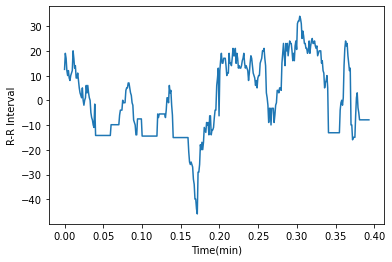